<a href="https://colab.research.google.com/github/OdysseusPolymetis/ariane_classes/blob/main/3_vecteurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Vecteurs de mots</center>

In [ ]:
import os
import gensim
from gensim.models import Word2Vec
import glob
import nltk
import spacy
from lxml import etree as ET
import lxml.html
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
!python -m spacy download fr_core_news_sm
nlp = spacy.load('fr_core_news_sm', disable=["ner", "parser"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2023-11-08 13:35:18.520611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 13:35:18.520686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 13:35:18.520726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 13:35:19.806213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 59.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [ ]:
!gdown --id 14C7h-bNGv_59RaM0YXY5g4gxhCp0VowP
!unzip /content/auteurs.zip

In [ ]:
dumas="/content/auteurs/dumas/"
frantext="/content/auteurs/frantext/"
balzac="/content/auteurs/balzac/"
hugo="/content/auteurs/hugo/"
verne="/content/auteurs/verne/"

## Section d'analyse : si vos textes viennent de Frantext, allez à la section suivante

In [ ]:
# Pour cette partie du code, il faut compter 5 minutes
if dumas:
    files = glob.iglob(f'{dumas}/**/*.xml', recursive=True)
    lemmatized_sentences = []
    num = 0

    for filename in files:
        p = ET.XMLParser(remove_blank_text=True, resolve_entities=False)
        tree = ET.parse(filename, p)
        root = tree.find(".//text")
        rawtext = lxml.html.tostring(root, method="text", encoding="utf8").decode().strip()

        sentences = sent_detector.tokenize(rawtext)
        for sentence in sentences:
            doc = nlp(sentence)
            lemmas = [token.lemma_.lower() for token in doc if len(token.lemma_) > 2 and not token.is_stop and token.is_alpha]
            lemmatized_sentences.append(lemmas)
            num += 1
            if num % 1000 == 0:
                print(num)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


In [ ]:
print(len(lemmatized_sentences))
print(lemmatized_sentences[10])

33839
['comte', 'essex', 'bague', 'splendide', 'enrichir', 'diamant', 'donner', 'royal', 'maître', 'simple', 'anneau', 'chiffre', 'date', 'anneau', 'être', 'bénir', 'chapelle', 'palais', 'royal', 'briser', 'vœu']


## Section pour Frantext

In [ ]:
def strip_ns_prefix(tree):
    query = "descendant-or-self::*[namespace-uri()!='']"
    for element in tree.xpath(query):
        element.tag = ET.QName(element).localname
    return tree

In [ ]:
if hugo != "":
    texts=""
    files= glob.iglob(verne+'/**/*.xml', recursive=True)
    sentences=list()
    for filename in files :
        print(filename)
        parser = ET.XMLParser(remove_blank_text=True, resolve_entities=False, encoding='utf8')
        tree = strip_ns_prefix(ET.parse(filename,parser))
        words = tree.xpath(".//wf/@lemma")
        sent=list()
        for word in words:
            sent.append(word)
            if word == ".":
                sentences.append(sent)
                sent=list()

In [ ]:
print(len(sentences))
print(sentences[5])

48549
['cependant', 'il', 'convenir', 'de', 'noter', 'que', 'le', 'pays', 'transylvain', 'être', 'encore', 'très', 'attacher', 'à le', 'superstition', 'de le', 'premier', 'âge', '.']


## Construction du modèle vectoriel

In [ ]:
model = Word2Vec(lemmatized_sentences, min_count=2,max_vocab_size=10000, negative=10, epochs=100)

In [ ]:
model.wv.save("./model_dumas_prelemmatized.bin")

In [ ]:
print(model.wv.index_to_key)

In [ ]:
#Paris est à France ce que Londres est à ? model.wv.most_similar(positive=['Londres', 'France'], negative=['Paris'],topn=5)
#roi est à homme ce que reine est à ? model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=5)
model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=10)

[('fille', 0.4247576594352722),
 ('gens', 0.4214635491371155),
 ('garçon', 0.4074735641479492),
 ('ministre', 0.3813636898994446),
 ('gentleman', 0.37879642844200134),
 ('enfant', 0.3785483241081238),
 ('femme', 0.3644982874393463),
 ('poignée', 0.3613751232624054),
 ('gardien', 0.3547166883945465),
 ('hottentot', 0.35231590270996094)]

## Visualisation

In [ ]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

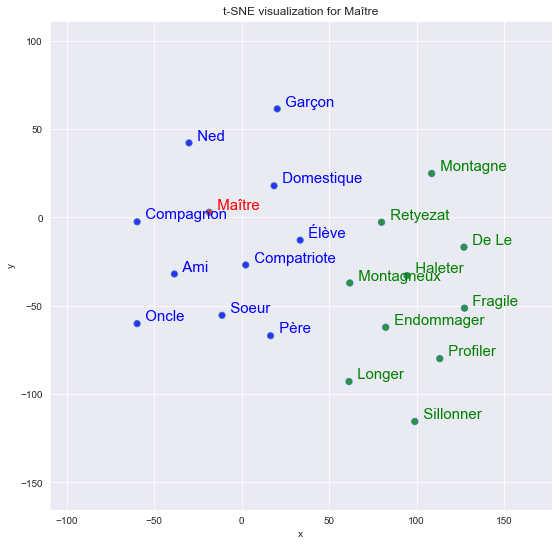

In [ ]:
tsnescatterplot(model, 'maître', [i[0] for i in model.wv.most_similar(negative=["maître"])])

Vous avez aussi accès à un visualiseur beaucoup plus performant que celui-ci, qui est disponible ici : <a href="https://projector.tensorflow.org/">Embeddings Projector</a>
<br><br>Pour l'utiliser, vous aurez besoin d'exécuter la cellule suivante et de mettre ensuite les fichiers obtenus (qui se trouveront dans le dossier "modeles") dans le projecteur (comme je vous montrerai en cours).

In [ ]:
with open('/content/tensorflow.tsv', 'w+') as tensors:
    with open( '/content/tensorflowmeta.tsv', 'w+') as metadata:
         for word in model.wv.index_to_key:
                metadata.write(word+'\n')
                vector_row = '\t'.join(map(str, model.wv[word]))
                tensors.write(vector_row + '\n')

/home/odysseus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
